# Dymas micromagnetic software examples
Author: Diego González Chávez  
email : diegogch@cbpf.br

## Micromagnetic Standar Problem 4

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#Dymas
import sys
sys.path.append("../") #Path to dymas package
import dymas

#Ubermag
import discretisedfield as df
import micromagneticmodel as mm

In [2]:
#Standar Problem 4 definition in ubermag

# Geometry
lx = 500e-9  # x dimension of the sample(m)
ly = 125e-9  # y dimension of the sample (m)
lz = 3e-9  # sample thickness (m)

# Material (permalloy) parameters
Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)

# Dynamics (LLG equation) parameters
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.02  # Gilbert damping

#cell = (5e-9, 5e-9, 3e-9) #Fine mesh.
cell = (25e-9, 25e-9, 3e-9) #Use a coarse mesh for faster simulation times
mesh = df.Mesh(p1=(0, 0, 0), p2=(lx, ly, lz), cell=cell)

system = mm.System(name='macrospin')
system.energy += mm.Exchange(A=A)
system.energy += mm.Demag()
system.energy += mm.Zeeman(H=[0,0,0])

system.dynamics += mm.Precession(gamma0=gamma0)
system.dynamics += mm.Damping(alpha=alpha)

system.m = df.Field(mesh, dim=3, value=(1, 0.25, 0.1), norm=Ms)

In [3]:
#Import the ubermag system
S = dymas.System.fromUbermagSystem(system)

#Find the equilibrium position
dymas.Minimize(S)

#Store the equilibrium position for later
m_eq = S.m.copy()

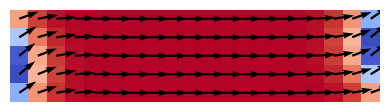

In [4]:
# Plot the equibrim state
plt.close('Static M')
fig = plt.figure('Static M', (4,2))
sp = fig.add_subplot(1,1,1)

#Reconstruct m into a 3D array
m3D = np.zeros((*S.mesh_n, 3))
m3D[~S.mask] = m_eq

xs = np.arange(0, S.mesh_n[0], 1)
ys = np.arange(0, S.mesh_n[1], 1)
X, Y = np.meshgrid(xs, ys)

#Plot x direction as color 
sp.imshow(m3D[:,:,0,0].T, 
       origin = 'lower', 
       cmap = 'coolwarm',
       interpolation = 'none',
       aspect = 1
       )

#Use x,y directions for arrows
n = 1 #draw an arrow every n grid cells
sp.quiver(X[::n,::n], Y[::n,::n], 
          m3D[::n,::n,0,0].T, m3D[::n,::n,0,1].T)
sp.set_xticks([])
sp.set_yticks([])
plt.tight_layout()

### Stage 1

In [5]:
#Simulate stage1 using dymas
#For the coarse mesh (25x25x3)nm³ this should run in a few seconds.
#For the fine mesh (5x5x3)nm³ this will take several minutes.

S.m = m_eq.copy()
H1 = (-24.6e-3/mm.consts.mu0, 4.3e-3/mm.consts.mu0, 0.0) #Stage field
S.H = S.H*0 + H1

simulation_time = 1e-9 #Total simulation time in s
samples = 200
delta_time = simulation_time/samples

#Get the simulation time at each sample
t_stage1 = np.linspace(0, simulation_time, samples+1)[1:]

#Get an output field m for each sample
m_out = []
for i in range(samples):
    dymas.Evolve(S, delta_time, max_steps=50000)
    m_out.append(S.m.copy())

#Get the mean value of the y component of m for each sample
m_y_stage1 = np.array(m_out).mean(axis=1)[:,1]

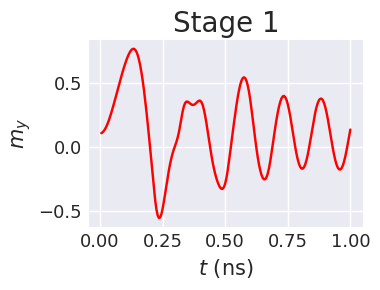

In [6]:
#Plot the resutls

plt.close('Stage1')
plt.figure('Stage1', (4,3))
plt.plot(t_stage1/1E-9, m_y_stage1, 'r-')
plt.grid(True)
plt.ylabel(r'$m_y$')
plt.xlabel(r'$t\,\, \mathrm{(ns)}$')
plt.title("Stage 1")
plt.tight_layout()

### Stage 2

In [7]:
S.m = m_eq.copy()
H2 = (-35.5e-3/mm.consts.mu0, -6.3e-3/mm.consts.mu0, 0.0) #Stage field
S.H = S.H*0 + H2

simulation_time = 1e-9 #Total simulation time in s
samples = 200
delta_time = simulation_time/samples

#Get the simulation time at each sample
t_stage2 = np.linspace(0, simulation_time, samples+1)[1:]

#Get an output field m for each sample
m_out_2 = []
for i in range(samples):
    dymas.Evolve(S, delta_time, max_steps=50000)
    m_out_2.append(S.m.copy())

#Get the mean value of the y component of m for each sample
m_y_stage2 = np.array(m_out_2).mean(axis=1)[:,1]

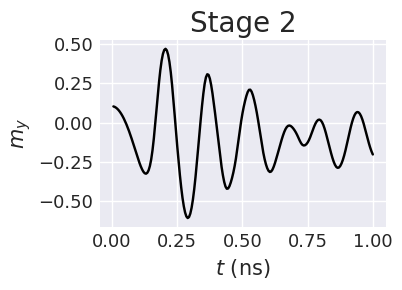

In [8]:
#Plot the resutls

plt.close('Stage2')
plt.figure('Stage2', (4,3))
plt.plot(t_stage2/1E-9, m_y_stage2, 'k-')
plt.grid(True)
plt.ylabel(r'$m_y$')
plt.xlabel(r'$t\,\, \mathrm{(ns)}$')
plt.title("Stage 2")
plt.tight_layout()